In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns

from utils import FEATURES_DIR, RESULTS_DIR
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DISTANCE_METRICS

import pickle

from notebook_utils import load_results_data, add_avg_subject

In [2]:
all_data = load_results_data()

all_data["alpha"] = all_data.alpha.astype("category")

distance_metric = 'cosine'
all_data

,alpha,model,subject,features,training_mode,testing_mode,fold,best_val_loss,best_val_acc,metric,value,model_feat
0,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,val_loss,0.949988,bert-large-uncased_lang
1,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,val_rsa,0.019661,bert-large-uncased_lang
2,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,rsa,0.135431,bert-large-uncased_lang
3,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,acc_cosine,0.804451,bert-large-uncased_lang
4,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,acc_cosine_captions,0.775155,bert-large-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...,...
15969,10000000.0,vit_l_16,sub-07,vision,train,test,4.0,False,False,rsa,0.101982,vit_l_16_vision
15970,10000000.0,vit_l_16,sub-07,vision,train,test,4.0,False,False,acc_cosine,0.734058,vit_l_16_vision
15971,10000000.0,vit_l_16,sub-07,vision,train,test,4.0,False,False,acc_cosine_captions,0.681781,vit_l_16_vision
15972,10000000.0,vit_l_16,sub-07,vision,train,test,4.0,False,False,acc_cosine_images,0.836232,vit_l_16_vision


In [3]:
distance_metric = 'cosine'
METRICS = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images']

def plot_metrics(data, hue_variable="model_feat", row_variable=None, metrics=METRICS, ylim=(0.5, 1), add_avg_over_subjects=True, plot_legend=True, palette=None):
    data_filtered = data[data.metric.isin(metrics)]
    if add_avg_over_subjects:
        data_filtered = add_avg_subject(data_filtered)

    sns.set_style("ticks", {'axes.grid' : True})
    g = sns.catplot(data_filtered, kind="bar", x="subject", y="value", row=row_variable, col="metric", col_order=metrics, height=6, aspect=1.7, hue=hue_variable, palette=palette, err_kws={'linewidth': 0.5})
    g._legend.remove()
    bbox_extra_artists = None
    if plot_legend:
        lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(1, 0.9), ncol=2)
        bbox_extra_artists = (lgd,)

    g.set(ylim=ylim)
    
    # plt.suptitle("Test Performance", fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(RESULTS_DIR, f"{hue_variable}_comparison_{metrics[0]}.png"), bbox_extra_artists=bbox_extra_artists, bbox_inches='tight', dpi=300)
    return g, data_filtered

## Model selection based on val loss vs. val pairwise acc

(<seaborn.axisgrid.FacetGrid at 0x7fd792769b20>,
             alpha               model  subject features training_mode  \
 0          1000.0  bert-large-uncased   sub-01     lang         train   
 3          1000.0  bert-large-uncased   sub-01     lang         train   
 6          1000.0  bert-large-uncased   sub-01     lang         train   
 7          1000.0  bert-large-uncased   sub-01     lang         train   
 10         1000.0  bert-large-uncased   sub-01     lang         train   
 ...           ...                 ...      ...      ...           ...   
 15963  10000000.0            vit_l_16  average   vision         train   
 15966  10000000.0            vit_l_16  average   vision         train   
 15967  10000000.0            vit_l_16  average   vision         train   
 15970  10000000.0            vit_l_16  average   vision         train   
 15973  10000000.0            vit_l_16  average   vision         train   
 
       testing_mode  fold  best_val_loss  best_val_acc       

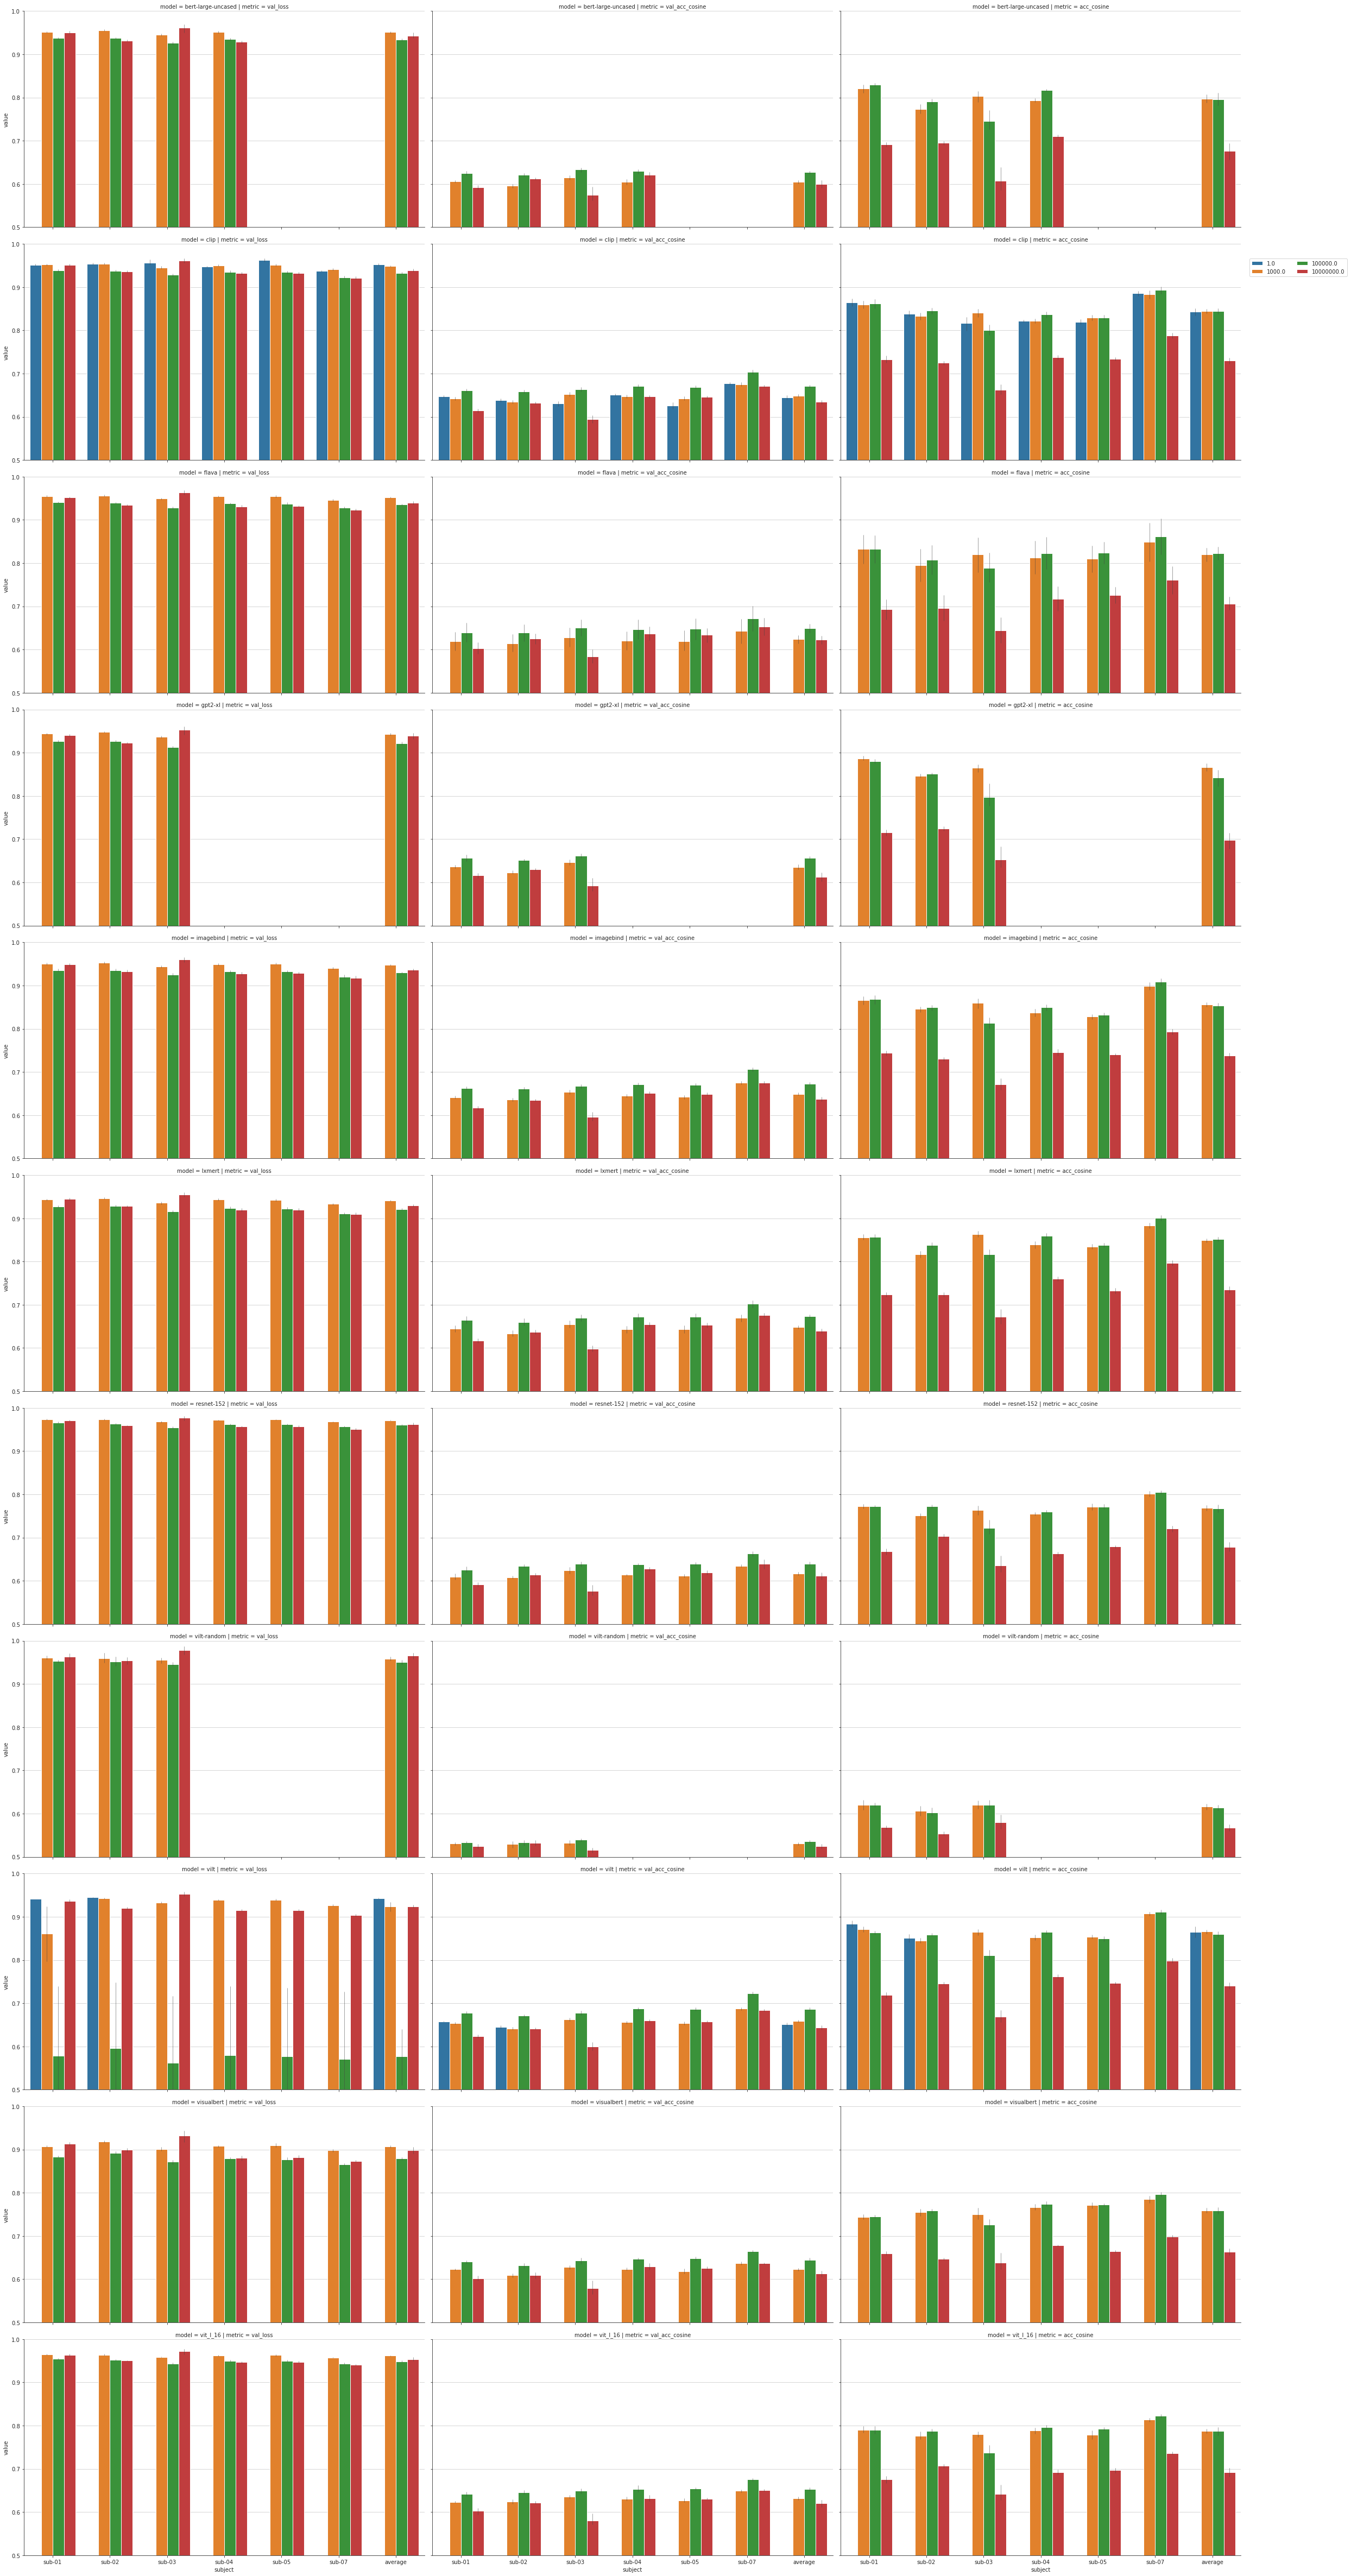

In [7]:
metrics = ['val_loss', f'val_acc_{distance_metric}', f'acc_{distance_metric}'] #, 'val_rsa'

data_to_plot = all_data
data_to_plot = data_to_plot[data_to_plot.best_val_loss == False]
data_to_plot = data_to_plot[data_to_plot.best_val_acc == False]

_ = plot_metrics(data_to_plot, metrics=metrics, ylim=(0.5, 1), hue_variable="alpha", row_variable="model")

## Final training on full training set

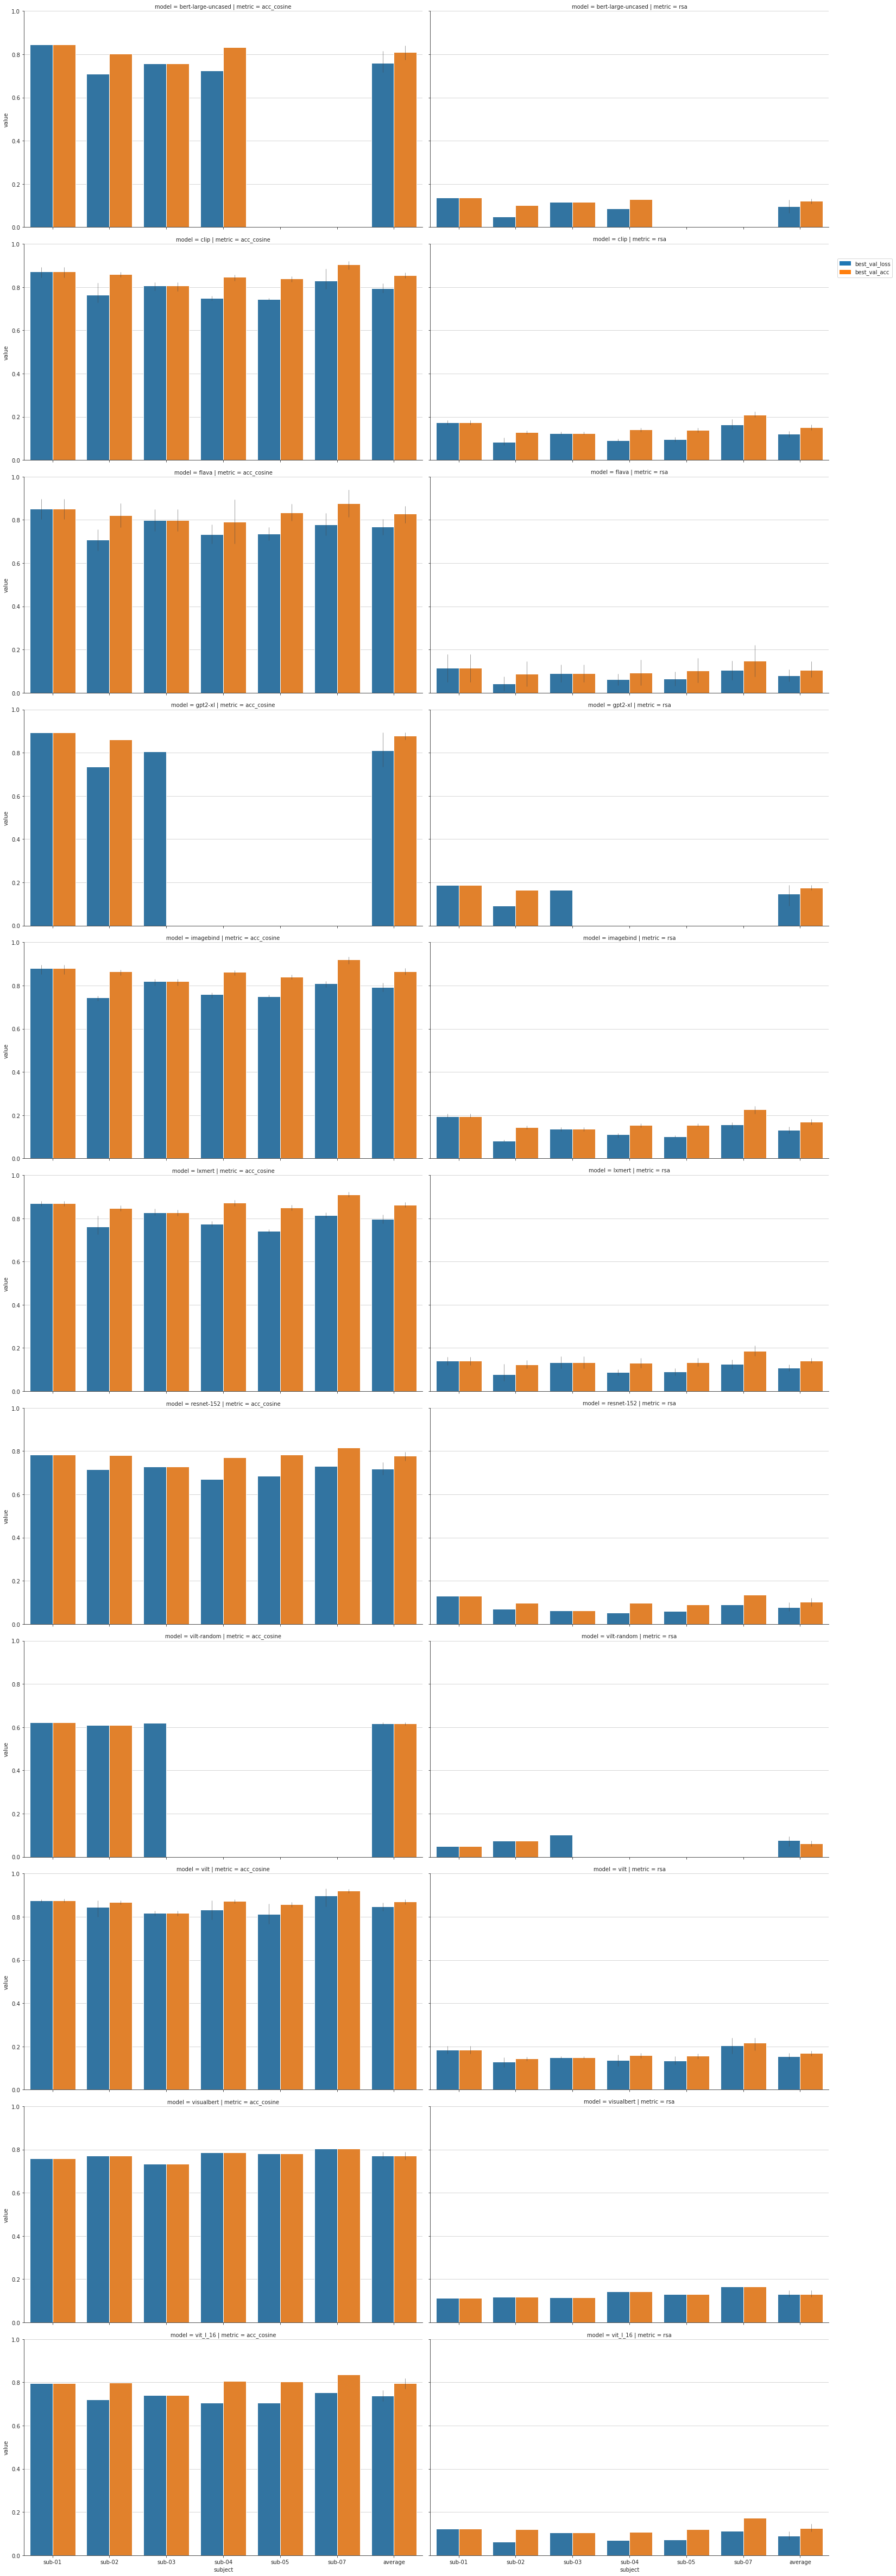

In [8]:
metrics = [f'acc_{distance_metric}', 'rsa']

data_to_plot = all_data
data_to_plot = data_to_plot[(data_to_plot.best_val_loss == True) | (data_to_plot.best_val_acc == True)]

g, _ = plot_metrics(data_to_plot, metrics=metrics, ylim=(0, 1), hue_variable="best_val_acc", row_variable="model", plot_legend=False)

g.fig.legend(handles=[mpatches.Patch(color=sns.color_palette()[0], label='best_val_loss'),  mpatches.Patch(color=sns.color_palette()[1], label='best_val_acc')], loc='upper left', title="", bbox_to_anchor=(1, 0.9))


## 